# Overview

This script creates a support vector machine to predict intellegence scores from patterns of fMRI resting-state connectivity, often called a connectome. The data is taken from [the human connectome project](https://www.humanconnectome.org/study/hcp-young-adult) and contain just over 1,000 participants. The connectome data is derived from fMRI scans measuring brain activity. These scans were used to compute mean brain activity over time for 100 brain regions. Correlations were computed between each pair of brain regions, yeilding 10,000 estimates of connectivity for each participant. We are using these connectivity scores to predict intellegence scores that are the combination of estimates of fluid intellegence and crystalized intellegence, as measured by the NIH Toolbox Cognition Battery (see https://europepmc.org/article/PMC/4103789).

# Setup

Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from itertools import product

Load in the data, which was downloaded from [the human connectome project database](https://db.humanconnectome.org/) unzipped, formatted and split into training (n=853) and test (n=150) sets with the script prepData.py. The DV is being set to 'CogTotalComp_Unadj' a of intellegence.

In [2]:
# set paths
data_dir = '/mnt/f/portfolio/data/HCPrest'
train_csv = os.path.join(data_dir,'netmatBehTrain.csv')
test_csv = os.path.join(data_dir,'netmatBehTest.csv')

# set DV
y_var = 'CogTotalComp_Unadj'

# read in data
train_df = pd.read_csv(train_csv, index_col=0)
test_df = pd.read_csv(test_csv, index_col=0)

# subset data to just the resting
trainAbr_df = train_df.iloc[:,0:9998].join(train_df[y_var])
testAbr_df = test_df.iloc[:,0:9998].join(test_df[y_var])

To get a sense of the distribution of the DV, plot a histogram (in dark cyan, for no particular reason) and print minimum and maximum zscores. Data are fairly normally distributed, except for a larger than expected number of participants who performed partcularly well, around 150. SVM doesn't require normally distributed data, so what's most important is that none of the data looks incorrect (ex. nobody scored a 0), and there is a decent range of values to predict.

2.1454172161484575
-2.3667167141772643


<AxesSubplot:xlabel='CogTotalComp_Unadj', ylabel='Count'>

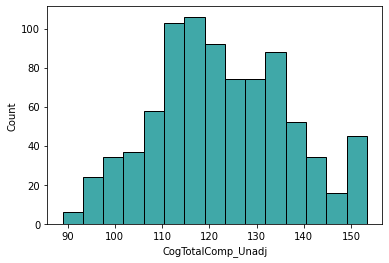

In [3]:
train_z = zscore(train_df[y_var],nan_policy='omit')
print(np.nanmax(train_z))
print(np.nanmin(train_z))

sns.histplot(train_df[y_var], color='darkcyan')

Find the number of participants missing intellegence scores, and drop those participants. Only participants with complete fmri images were included in the dataset provided by HCP, so the resting-state data do not have any missing observations.

In [4]:
df_dict = {'training set':trainAbr_df,'test set':testAbr_df}
for dsetname,dset in df_dict.items():
    colNA = dset.columns[dset.isna().any()].tolist()
    rowNA = np.count_nonzero(dset.isnull())
    print(f'{dsetname}\n   rows with missing values: '
      f'{rowNA} from {colNA}')

trainAbr_df = trainAbr_df.dropna()
testAbr_df = testAbr_df.dropna()

training set
   rows with missing values: 10 from ['CogTotalComp_Unadj']
test set
   rows with missing values: 2 from ['CogTotalComp_Unadj']


Split the training dataset into train and validation subsets. This gives us a separate subset of data we can use to tune the model, before testing the model on our test dataset. Print the first few lines of the train data.

In [5]:
x_train, x_validation, y_train, y_validation = train_test_split(trainAbr_df.iloc[:,0:9998], trainAbr_df[y_var], random_state=99, test_size=150)
print(y_train.head())
x_train.head()

Subject
136227    108.74
580044    117.63
589567    118.79
169545    147.43
818859    108.58
Name: CogTotalComp_Unadj, dtype: float64


,1,2,3,4,5,6,7,8,9,10,...,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998
Subject,,,,,,,,,,,,,,,,,,,,,
136227,-1.25450,12.005,-5.5846,0.90102,0.081022,1.72100,4.68060,3.0006,-1.75730,-10.7500,...,-0.24152,1.57480,0.306160,0.237690,2.5667,2.6962,0.27102,0.151570,2.4707,-0.032852
580044,-0.98619,11.135,-7.0761,0.34346,4.512800,3.98390,-0.72145,4.9632,0.77433,-9.4177,...,-0.92474,0.64547,1.365100,0.018747,2.2649,2.4243,0.28878,0.007558,1.5671,1.680600
589567,0.42500,15.603,-7.9747,-0.22150,1.913200,-0.45176,-4.32130,1.8379,-0.31283,0.9523,...,1.14920,-0.10343,0.505970,1.074200,2.1428,2.6968,1.46970,0.152710,3.7218,0.785820
169545,0.28833,14.792,-10.4890,1.32850,4.587800,1.96890,1.12280,2.3035,-2.05350,-8.2960,...,-0.20352,0.91074,-0.069628,1.495400,2.2064,2.4044,1.07980,1.318200,3.7005,0.137110
818859,-1.89840,16.073,-4.9717,-1.12990,2.801300,2.51860,-3.05430,1.7590,-3.02070,-10.8870,...,0.97934,0.98698,-0.322040,1.051400,2.7738,3.1146,-0.89043,-0.521210,2.0933,-0.896210


Scale the train data, and apply the same scaling factor to the validation data. Scaling is not done on the pooled data, to prevent data leakage - passing information about the validation/test dataset to the training dataset.

In [6]:
# scale the data

# scale x
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
# apply the scaling to the test set that we computed for the training set
x_validation_scaled = x_scaler.transform(x_validation)

# scale y
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
# apply the scaling to the validation set that we computed for the training set
y_validation_scaled = y_scaler.transform(y_validation.values.reshape(-1,1))

# Model Selection
Use GridSearchCV to search for the combination of basis functions and accompanying parameters that result in the highest cross validated R^2. To make sure we're test a wide range of values, we're using a log scale test 8 values from .0001 to 1000 for both C and gamma. As these take a while to compute, it is nice to time the process, in case you have to run it more than once, you have an idea of how long it will take.

In [7]:
%%time

# Initial grid search for best SVM parameters based on training set only

param_grid = [
  {'C': np.geomspace(.0001,1000,num=8), 'kernel': ['linear']},
  {'C': np.geomspace(.0001,1000,num=8), 'kernel': ['poly'], 'degree':[2,3,5], 'gamma': np.geomspace(.0001,1000,num=8)},
  {'C': np.geomspace(.0001,1000,num=8), 'gamma': np.geomspace(.0001,1000,num=8), 'kernel': ['rbf']}
 ]

grid_search = GridSearchCV(SVR(),
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1)
grid_search.fit(x_train_scaled, y_train_scaled.ravel())
print(grid_search.best_params_)

#{'C': 0.01, 'kernel': 'linear'}

{'C': 0.01, 'kernel': 'linear'}
CPU times: user 7.26 s, sys: 557 ms, total: 7.82 s
Wall time: 25min 59s


Run SVR based on the parameters obtained from cross-validation, and calculate fit for both the training and validation datasets. The fit looks substantially better (higher R^2 and lower MSE) in the training than validation set, which suggests overfitting of the training set.

In [8]:
svr = SVR(C=.01, kernel = 'linear').fit(x_train_scaled,y_train_scaled.ravel())
train_yfit = svr.predict(x_train_scaled)

score = svr.score(x_train_scaled,y_train_scaled)
print("train R-squared:", score)
print("train MSE:", mean_squared_error(y_train_scaled, train_yfit),'\n')

score = svr.score(x_validation_scaled,y_validation_scaled)
validation_yfit = svr.predict(x_validation_scaled)
print("validation R-squared:", score)
print("validation MSE:", mean_squared_error(y_validation_scaled, validation_yfit),'\n')


train R-squared: 0.8444437265010829
train MSE: 0.007787843554590562 

validation R-squared: 0.19997918543564375
validation MSE: 0.03578939863803841 



Try to further triangulate the best parameters for the model.  This time, rather than using cross-validation of the training set, search for the parameters that lead to the best fit on our validation set.

In [9]:
# List of dictionaries with paramters to run through for each kernel.
param_grid = [
  {'kernel': ['linear'], 'C': np.geomspace(.0001,1000,num=8), 
   'degree':['NA'], 'gamma':['NA']},
  {'kernel': ['poly'], 'C': np.geomspace(.0001,1000,num=8), 
   'degree':[2,3,5], 'gamma': np.geomspace(.0001,1000,num=8)},
  { 'kernel': ['rbf'],'C': np.geomspace(.0001,1000,num=8), 
   'degree':['NA'], 'gamma': np.geomspace(.0001,1000,num=8)}
 ]

results_dict = {}
i = 0
# For each kernal, fit each combination of parameters, computer R^2 and MSE
# for the training and validation data sets and store in a dictionary
for param_dict in param_grid:
    for C,degree,gamma in product(
        param_dict['C'],param_dict['degree'],param_dict['gamma']):
        
        i += 1
        
        # Run the appropriate SVR model for given iteration
        if degree == 'NA':
            if gamma == 'NA':
                svr = SVR(C=C, kernel='linear').fit(
                    x_train_scaled,y_train_scaled.ravel())
            else:
                svr = SVR(C=C, kernel='rbf', gamma=gamma).fit(
                    x_train_scaled,y_train_scaled.ravel())
        else:
            svr = SVR(C=C, kernel='poly', gamma=gamma, degree=degree).fit(
                    x_train_scaled,y_train_scaled.ravel())
  
        # Compute R^2 and MSE for training data
        train_R2 = svr.score(x_train_scaled,y_train_scaled)
        train_yfit = svr.predict(x_train_scaled)
        train_mse = mean_squared_error(y_train_scaled, train_yfit)

        # Compute R^2 and MSE for validation data
        validation_R2 = svr.score(x_validation_scaled,y_validation_scaled)
        validation_yfit = svr.predict(x_validation_scaled)
        validation_mse = mean_squared_error(y_validation_scaled, validation_yfit)

        # store results in dictionary
        tmp_result_dict = {i : {
                                'kernel':param_dict['kernel'],
                                'degree':degree,
                                'C':C,
                                'gamma':gamma,
                                'train_R2':train_R2,
                                'train_mse':train_mse,
                                'validation_R2':validation_R2,
                                'validation_mse':validation_mse}}

        results_dict.update(tmp_result_dict)


Print first few rows of dictionary, sorted by R^2 for the validation dataset. Results aren't too different from cross-validation. The linear kernel still came out on top, but with a bit smaller C value. This suggests a wider margin may provide better out-of-sample model fit. However, we are still seeing substantially better fit for the training dataset, than the validation set. This is likely due, in large part, do have many more dimensions (predictor variables) than observations. If we had a larger dataset, we may be able to get better fit.

In [10]:
pd.DataFrame.from_dict(results_dict, orient='index').sort_values('validation_R2',ascending=False).head()

,kernel,degree,C,gamma,train_R2,train_mse,validation_R2,validation_mse
2,[linear],NA,0.0010,NA,0.768730,0.011578,0.215340,0.035102
234,[rbf],NA,1.0000,0.001,0.838213,0.008100,0.212931,0.035210
74,[poly],5,0.0100,0.001,0.844300,0.007795,0.212321,0.035237
193,[poly],5,1000.0000,0.0001,0.844301,0.007795,0.212286,0.035239
19,[poly],3,0.0001,0.01,0.843245,0.007848,0.210858,0.035303


Here we are using the same code, but with different parameter inputs, to fine tune the C parameter. From the prior step we know that setting C to .001 resulted in better model performance in our validation dataset than setting C to either .0001 or .001, but what about values in between those? Here we stick with the linear kernel, but search for C values between .0001 and .001 that may result in better performance.

In [29]:
# List of dictionaries with paramters to run through for each kernel.
param_grid = [
  {'kernel': ['linear'], 'degree':['NA'], 'gamma':['NA'],
   'C': np.linspace(.0001,.01,num=100)}
 ]

fine_tune_dict = {}
i = 0
# For each kernal, fit each combination of parameters, computer R^2 and MSE
# for the training and validation data sets and store in a dictionary
for param_dict in param_grid:
    for C,degree,gamma in product(
        param_dict['C'],param_dict['degree'],param_dict['gamma']):
        
        i += 1
        
        # Run the appropriate SVR model for given iteration
        if degree == 'NA':
            if gamma == 'NA':
                svr = SVR(C=C, kernel='linear').fit(
                    x_train_scaled,y_train_scaled.ravel())
            else:
                svr = SVR(C=C, kernel='rbf', gamma=gamma).fit(
                    x_train_scaled,y_train_scaled.ravel())
        else:
            svr = SVR(C=C, kernel='poly', gamma=gamma, degree=degree).fit(
                    x_train_scaled,y_train_scaled.ravel())
  
        # Compute R^2 and MSE for training data
        train_R2 = svr.score(x_train_scaled,y_train_scaled)
        train_yfit = svr.predict(x_train_scaled)
        train_mse = mean_squared_error(y_train_scaled, train_yfit)

        # Compute R^2 and MSE for validation data
        validation_R2 = svr.score(x_validation_scaled,y_validation_scaled)
        validation_yfit = svr.predict(x_validation_scaled)
        validation_mse = mean_squared_error(y_validation_scaled, validation_yfit)

        # store results in dictionary
        tmp_result_dict = {i : {
                                'kernel':param_dict['kernel'],
                                'degree':degree,
                                'C':C,
                                'gamma':gamma,
                                'train_R2':train_R2,
                                'train_mse':train_mse,
                                'validation_R2':validation_R2,
                                'validation_mse':validation_mse}}

        fine_tune_dict.update(tmp_result_dict)


Having tested other values, we find in the resulting table that the previously obtained value for C, .001, seems to be the best.

In [31]:
pd.DataFrame.from_dict(fine_tune_dict, orient='index').sort_values('validation_R2',ascending=False).head()

,kernel,degree,C,gamma,train_R2,train_mse,validation_R2,validation_mse
10,[linear],NA,0.0010,NA,0.768730,0.011578,0.215340,0.035102
11,[linear],NA,0.0011,NA,0.784859,0.010771,0.215161,0.035110
12,[linear],NA,0.0012,NA,0.798231,0.010101,0.214395,0.035144
9,[linear],NA,0.0009,NA,0.749380,0.012547,0.213728,0.035174
13,[linear],NA,0.0013,NA,0.808851,0.009570,0.213011,0.035206


Fit the model with our chosen value for C, and plot the predicted scaled intellegence scores against actual scaled intellegence scores for the validation set. You can see visually that there is a correlation, indicating that the model is able to give us some information about the likely intellegence score from brain connectivity patterns, although the prediction is far from perfect.

Text(0, 0.5, 'Predicted Intellegence Score')

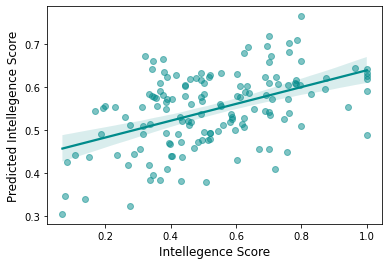

In [33]:
svr = SVR(C=.001, kernel = 'linear').fit(x_train_scaled,y_train_scaled.ravel())

validation_yfit = svr.predict(x_validation_scaled)

validation_plot=sns.regplot(x=y_validation_scaled,y=validation_yfit,
        scatter_kws={'alpha':0.5, 'color':'darkcyan'}, 
        line_kws={'color':'darkcyan'})
validation_plot.set_xlabel("Intellegence Score", fontsize = 12)
validation_plot.set_ylabel("Predicted Intellegence Score", fontsize = 12)

# Model Evalution
Now we test the model on the test dataset, that was held out from the beginning. Since this data was not used to train or tune our model in any way, this will give us an unbiased estimate of the accuracy of our model. With an R^2 of .268, the model is predicting intellegence scores in our test dataset a bit better than it did for our validation dataset.

In [14]:
x_test = testAbr_df.iloc[:,0:9998]
y_test = testAbr_df.loc[:,y_var]

# Apply scaling calculated on training data to test data

# scale x
x_test_scaled = x_scaler.transform(x_test)
# scale y
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1,1))

# fit the test data, and calculate R^2 and MSE
score = svr.score(x_test_scaled,y_test_scaled)
test_yfit = svr.predict(x_test_scaled)
print("test R-squared:", score)
print("test MSE:", mean_squared_error(y_test_scaled, test_yfit),'\n')

test R-squared: 0.2631142084197098
test MSE: 0.041236881044810936 



Finally, we visualize model fit for the test dataset. As in our validation set, we can see that the model has some ability to predict intellegence from patterns of brain connectivity, although imperfectly.

Text(0, 0.5, 'Predicted Intellegence Score')

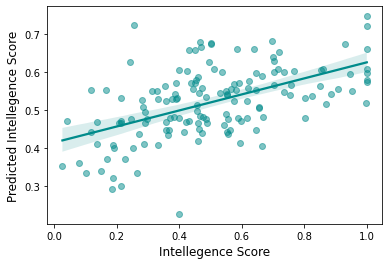

In [15]:
test_plot=sns.regplot(x=y_test_scaled,y=test_yfit,
                      scatter_kws={'alpha':0.5,'color':'darkcyan'},
                      line_kws={'color':'darkcyan'})
test_plot.set_xlabel("Intellegence Score", fontsize = 12)
test_plot.set_ylabel("Predicted Intellegence Score", fontsize = 12)

# Conclusion
In this script we built a support vector machine model to predict intellegence scores from patterns of brain connectivity. The model was able to account for 26.8% of the variance in intellegence scores. While this model would not be adequate to predict an individual's intellegence with a high degree of accuracy, it does demonstrate that an individuals patterns of brain connectivity can give us information about their intellegence. I've done a lot of (non-ML) work looking at simple correlations between fmri measures of brain activity and emotion, personality and cognition - and am used to the strongest of those associations having an R^2 of less then .1. So it is interesting that patterns of brain connectivity on this macro level (looking at connectivity between 100 regions, vs. individual cells) contain enough information about intellegence to account for 26.8% of the variance.

It would be interesting to see if training a similar model on a larger number of participants would allow us to predict intellegence scores with greater accuracy. The low number of participants (1003) relative to the number of features (10,000) used here likely resulted in an overfit model, as our accuracy in the training dataset was substantially better than in the validation and test sets, even after searching for a set of parameters that would perform well in the validation set. Nevertheless, this model provides proof of concept that brain connectivity patterns contain information about an individual's intellegence score.